In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy import ndimage, sparse, linalg
from skimage.color import label2rgb, rgb2lab
from skimage.feature import local_binary_pattern
import pyrtools as pt
from tqdm import tqdm

from utils import im2double, gauss2D, local_min, get_weights, seg2bmap
from tqdm import tqdm

In [2]:
def get_speed_based_on_gradient(img, normSigma=5):
    [gx,gy] = np.gradient(255*img)
    mag = np.sqrt(gx**2 + gy**2)
    filt = np.array([1])
    filt = filt.reshape((1,-1))
    ss_mag = pt.corrDn(mag, filt,'repeat', step=[2, 2])
    stdev = normSigma
    nTaps = np.round(3*stdev) * 2 + 1
    
    lpImpResp = gauss2D((1,nTaps),stdev)
    lpImpResp = lpImpResp / np.max(lpImpResp)
    smooth_ssmag0 = ndimage.convolve(ss_mag, lpImpResp)
    smooth_ssmag = ndimage.convolve(smooth_ssmag0, lpImpResp.conj().T)

    f = np.array([0.5,1.0,0.5]).conj().T
    f = f.reshape(-1,1)
    res = pt.upConv(smooth_ssmag,f,'reflect1',step=[2,1])
    smooth_mag = pt.upConv(res,f.conj().T,'reflect1',step=[1,2])

    smooth_mag = smooth_mag / (np.sqrt(2*np.pi) * stdev)
    if (smooth_mag.shape[0] != mag.shape[0]):
        smooth_mag = smooth_mag[:-1,:]
    if (smooth_mag.shape[1] != mag.shape[1]):
        smooth_mag = smooth_mag[:,:-1]
    magHalfHeight = 10.0
    normGradMag = 127 * (mag / (magHalfHeight + smooth_mag))
    speed = np.exp(-normGradMag/10)
    Dx= np.exp(normGradMag/10)
    return Dx,speed

def get_seeds_orig(img,num_seeds,speed):
    size_grid = np.sqrt(np.size(img) / num_seeds)
    rows = img.shape[0] / size_grid
    cols = img.shape[1] / size_grid
    size_grid_row = img.shape[0] / math.ceil(rows)
    size_grid_col = img.shape[1] / math.ceil(cols)
    [x,y] = np.mgrid[0:math.ceil(rows-1)+1,0:math.ceil(cols-1)+1]
    x = x.astype(float).T
    y = y.astype(float).T
    y = y*size_grid_col + size_grid_col/2
    x = x*size_grid_row + size_grid_row/2
    
    mag = 1-speed
    
    minDistBetweenSeeds = min(size_grid_row,size_grid_col)
    seedRadius = 1
    
    maxShift = math.floor((minDistBetweenSeeds - 2*seedRadius) / 2) - 1
    N = math.ceil(maxShift/2)
    [dx,dy] = local_min(img,N)
    ind = np.hstack((x.astype("int")[0,:],y.astype("int")[:,0]))
    x_row = list(x[0,:].astype("int")-1)
    y_row = list(y[:,0].astype("int")-1)
    new_x = dx[np.ix_(x_row, y_row)].T
    new_y = dy[np.ix_(x_row, y_row)].T
    x = new_x
    y = new_y
    off = 2
    x_trun = x.copy()
    x_trun[x_trun>(img.shape[0]-off)] = img.shape[0]-off
    y_trun = y.copy()
    y_trun[y_trun>(img.shape[1]-off)] = img.shape[1]-off
    x = x_trun
    x[x<(1+off)] = 1+off
    y = y_trun.copy()
    y[y<(1+off)] = 1+off
    
    seeds = np.vstack((x.flatten(),y.flatten())).T
    return seeds   

def generate_seeds(Nsp,img):
    n_init = np.round(Nsp/4)
    expSuperPixelDist = np.sqrt(np.size(img)/n_init)
    normSigma = math.floor(expSuperPixelDist / 2.5)
    _,speed = get_speed_based_on_gradient(img,normSigma)
    seeds = get_seeds_orig(img,n_init,speed)
    return seeds

In [3]:
# Params
Nsp=200 #num of sp
Thres=1.35 #threshold for split
beta=30 #gaussian parameter 
alpha=0.9992 #Lazy parameter
nItrs_max = 10 #limit for the number of iterations

In [4]:
IMG_PATH = '../bsds500/images/train/100075.jpg'
img = cv2.cvtColor(cv2.imread(IMG_PATH),cv2.COLOR_BGR2RGB)
scale_percent = 100
width = math.ceil(img.shape[1] * scale_percent / 100)
height = math.ceil(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
gray_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
orig_img = img.copy()
img = im2double(img)
X,Y,Z = img.shape

In [5]:
seeds = generate_seeds(Nsp,im2double(gray_img/255))
print(seeds[:5])

[[ 24.  30.]
 [ 73.  18.]
 [139.  29.]
 [189.  22.]
 [238.  19.]]


In [6]:
def LRW(adj, seeds, labels, alpha, size):
    """Find and optimize the superpixel results
    Args:
        adj: The adjacency matrix of the graph generated from image
        seeds: The seed positions (Row major form)
        labels: The labels corrosponding to the seeds
        alpha: Probability of staying put in LRW
        size: Size of the image
    Returns:
        image: Labeled image
        prob: The probability that the seed belongs to the label
    """
    I = sparse.coo_matrix((np.ones(size), 
                              (np.arange(size), np.arange(size))), 
                              shape=(size, size))
    D_inv = sparse.coo_matrix((1/np.array(adj.sum(axis=0)).ravel(), 
                              (np.arange(size), np.arange(size))), 
                              shape=(size, size))
    D_inv.eliminate_zeros()
    I.eliminate_zeros()
    labels = labels.T
    K = len(labels)
    lines = np.zeros(shape=(size, K))
    for k in range(K):
        label_idx = np.nonzero(labels.flatten() == k)[0]
        mk = label_idx.shape[0]
        lines[seeds[label_idx].astype(int), k] = 1 / mk
    D_inv_sqrt = D_inv.sqrt()
    S = D_inv_sqrt @ adj @ D_inv_sqrt
    new = (I-alpha*S)
    flk = sparse.linalg.spsolve(new, lines)
    likelihoods = np.zeros(shape=(size, len(labels)))
    for k in range(len(labels)):
        likelihoods[:,k] = flk[:,k]/np.sum(flk[:,k])
    sum_like = 1/np.sum(likelihoods, axis=1)
    probs = sparse.coo_matrix((sum_like, (np.arange(size), np.arange(size)))) @ likelihoods
    labels_idx = probs.argmax(axis=1)
    plt.show()
    prob = probs.max(1)
    return prob, labels_idx

def energy_opt(image, seeds, alpha, count, iters, sigma, thres):
    """Find and optimize the superpixel results
    Args:
        image: Original Image (RGB / Grayscale)
        seeds: The initial seed positions
        alpha: Probability of staying put in LRW
        count: Number of superpixels
        iters: Max number of iterations
        sigma: Gaussian parameter
        thres: Threshold to split bigger superpixels
    Returns:
        label: Labeled image
        seeds: The optimized seed positions
        iters: The number of iterations taken for convergence
    """
    pbar = tqdm(total=iters)
    height, width = image.shape[:2]
    
    lab = rgb2lab(image, illuminant='D65')

    # Generate adjacency matrix
    adj = get_weights(lab, sigma)
    gray_img = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
    LBP = local_binary_pattern(gray_img, 8, 1, 'uniform')#not sure if method should be uniform
    LBP = LBP/np.sum(LBP,axis=0)
    area_aver=np.sum(np.sum(LBP,axis=0))/count
    
    # Iteratvely improve superpixels
    new_seeds = seeds.copy()
    iter_num = 0
    while len(new_seeds) < count and iter_num <= iters:
        # Get labels and seed indices in row major form
        seeds_idx = new_seeds[:,0]*image.shape[1] + new_seeds[:,1]
        labels = np.arange(len(new_seeds))
        prob, labels_idx = LRW(adj, seeds_idx, labels, alpha, height*width)
        label_img = labels_idx.reshape((height, width))
        prob_map = prob.reshape((height, width))
        cmt = 1 - prob_map
        centers_new = []
        wx_all = np.exp(-(cmt/0.8)) # TODO: replace by phi
        for k in range(len(new_seeds)):
            r,c = np.nonzero(label_img == k)
            cmt_s = cmt[label_img == k]
            wx = wx_all[label_img == k]
            mask = np.tile(new_seeds[k,:], (len(r), 1))
            rc = np.vstack((r,c))
            dists = np.sqrt(np.sum(((mask-rc.T)**2),axis = 1))
            idx_centre = (dists == 0)
            cmt_s = np.delete(cmt_s, idx_centre, axis=0)
            r = np.delete(r, idx_centre, axis=0)
            c = np.delete(c, idx_centre, axis=0)
            dists = np.delete(dists, idx_centre, axis=0)
            wx = np.delete(wx, idx_centre, axis=0)
            mass=np.sum(wx*(cmt_s/dists), axis=0)
            cp_new = np.array([0,0])
            temp1 = np.sum(wx*(cmt_s/dists)*r, axis=0)/mass
            temp2 = np.sum(wx*(cmt_s/dists)*c, axis=0)/mass
            cp_new = np.hstack((temp1,temp2))
            if np.sqrt(np.sum((np.round(cp_new)-new_seeds[k,:])**2,axis=0))<=1.5:
                area_l=np.sum(LBP[label_img==k],axis=0) # compute the area of superpixel i
                lbpratio=area_l/area_aver
                if lbpratio>=thres:
                    mask = np.delete(mask,-1,0)
                    M=np.ones((2,2))
                    temp_Cs=cmt_s**2/dists**2
                    crd_diff=np.vstack((r,c)).T-mask
                    M = np.array([[0,0],[0,0]])
                    M[0,0]=np.sum(temp_Cs*crd_diff[:,0]**2,axis=0)
                    M[0,1]=np.sum(temp_Cs*crd_diff[:,0]*crd_diff[:,1],axis=0)
                    M[1,0]=M[0,1]
                    M[1,1]=sum(temp_Cs*crd_diff[:,1]**2)
                    U,_,_ = np.linalg.svd(M)
                    temp_split=crd_diff @ U[:,0]
                    cmt_s = cmt_s.reshape([-1,1])
                    temp_split = temp_split.reshape([-1,1])
                    dists = dists.reshape([-1,1])
                    mass1=np.sum(cmt_s[temp_split>0]/dists[temp_split>0],axis=0)
                    mass2=np.sum(cmt_s[temp_split<0]/dists[temp_split<0],axis=0)
                    c1 = np.array([0,0])
                    c2 = np.array([0,0])
                    r = r.reshape([-1,1])
                    c = c.reshape([-1,1])
                    c1[0]=np.sum((cmt_s[temp_split>0]/dists[temp_split>0])*r[temp_split>0],axis=0)/mass1
                    c1[1]=np.sum((cmt_s[temp_split>0]/dists[temp_split>0])*c[temp_split>0],axis=0)/mass1
                    c2[0]=np.sum((cmt_s[temp_split<0]/dists[temp_split<0])*r[temp_split<0],axis=0)/mass2
                    c2[1]=np.sum((cmt_s[temp_split<0]/dists[temp_split<0])*c[temp_split<0],axis=0)/mass2
                    centers_new.append(c1)
                    centers_new.append(c2)
                else:
                    centers_new.append(cp_new)
            else:
                centers_new.append(cp_new)
        centers_new = np.array(centers_new)
        new_seeds=np.round(centers_new)
        iter_num += 1
        pbar.update(1)
    seeds_idx = new_seeds[:,0]*width + new_seeds[:,1]
    labels = np.arange(len(new_seeds))
    prob, labels_idx = LRW(adj, seeds_idx, labels, alpha, height*width)
    label_img = labels_idx.reshape((height, width))
    return label_img, new_seeds, iter_num

In [7]:
res, seeds, iters = energy_opt(orig_img, seeds, alpha, Nsp, nItrs_max, beta, Thres)
bmap = seg2bmap(res,Y,X)
idx = np.nonzero(bmap>0)

bmapOnImg = img
temp = img[:,:,0]
temp[idx] = 1
bmapOnImg[:,:,0] = temp
if Z==3:
    temp=img[:,:,1]
    temp[idx]=0
    bmapOnImg[:,:,1] = temp
    temp=img[:,:,2]
    temp[idx]=0
    bmapOnImg[:,:,2] = temp



 90%|█████████ | 9/10 [02:15<00:15, 15.06s/it]


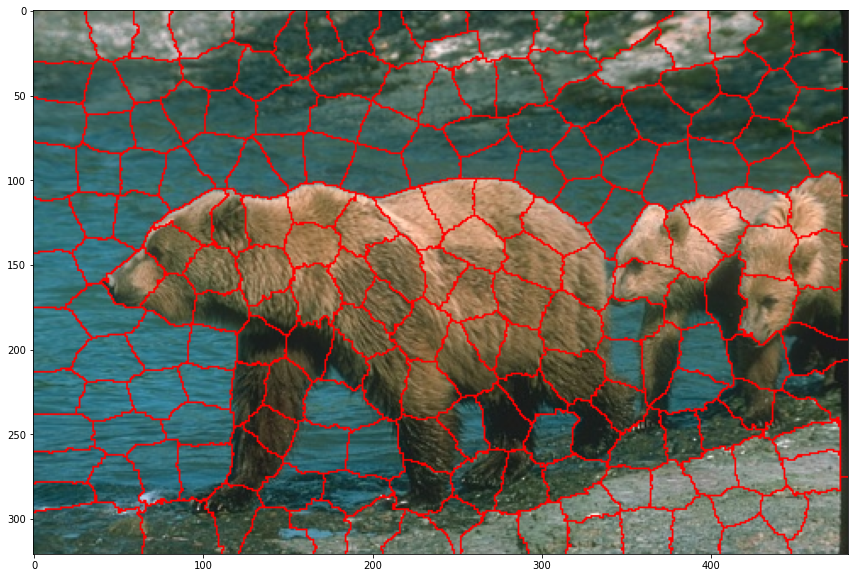

In [8]:
plt.figure(figsize = (20,10))
plt.imshow(bmapOnImg)
seeds_x = [i[0] for i in seeds]
seeds_y = [i[1] for i in seeds]

In [11]:
import pickle
with open('res.pkl', 'wb') as f:
    pickle.dump(res, f)

In [12]:
res.shape

(321, 481)